# Self-Driving Car Engineer Nanodegree


## Project \#1: **Finding Lane Lines on the Road**    
(built by Hector Angulo May 2017)
***
In this project, I built a computer vision pipeline to detect lanes lines using various image analysis and mathematical techniques.   The pipeline consists of:

1) Converting a single frame to grayscale

---

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


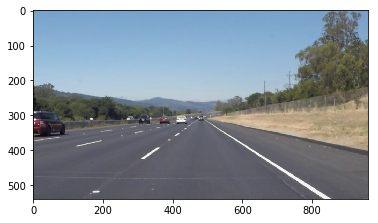

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [350]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=6):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    left_slopes = []
    right_slopes = []
    left_coordinates = []
    right_coordinates = []

    
    for line in lines:
        
        
        
        for x1,y1,x2,y2 in line:
            slope = ((y2-y1)/(x2-x1))

            ## Lets group into left and right lane
            if slope > .1 and slope < 100:   # Right lane
                #print("coordinate are (",x1,",",y1,") and (",x2,",",y2,") with a slope of", slope  )
                #print("The B for this line is", y1-slope*x1, "and also ", y2-slope*x2)
                right_slopes.append(slope)
                right_coordinates.append([x1,y1])
                right_coordinates.append([x2,y2])
              
                
            elif slope < -.1 and slope > -100:
                #print("coordinate are (",x1,",",y1,") and (",x2,",",y2,") with a slope of", slope  )
                #print("The B for this line is", y1-slope*x1, "and also ", y2-slope*x2)
                left_slopes.append(slope)
                left_coordinates.append([x1,y1])
                left_coordinates.append([x2,y2])
               
                
            else: 
                print("### Either horizontal or near vertical line ####")
                           
           # cv2.line(img, (x1,y1), (x2,y2), [0,0,255], 1)
                 
    average_left = sum(left_slopes)/ len(left_slopes)
    average_right = sum(right_slopes)/ len(right_slopes)
   # print("The average slope for right line is", average_right, "this includes ",len(right_slopes)," slopes")
   # print("The right slopes are", right_slopes)


    
    sorted_left = sorted(left_coordinates , key=lambda k: [k[0], k[1]])
    sorted_right = sorted(right_coordinates , key=lambda k: [k[0], k[1]])
    #print(" ORDERED list of left coordinates is:", sorted_left)
    #print(" ORDERED list of right coordinates is:", sorted_right)
    
    
    #Draw Left Line
    left_b= sorted_left[0][1] - average_left*sorted_left[0][0]      # calculate b for left line
    
    
    #Find out the bottom leftmost point (where X intersects max Y)     X=  (y-b) / m
    left_bottom_x = int((img.shape[0]-left_b)/average_left)
   
    

    bottom_left = (left_bottom_x, img.shape[0])
    last_coordinate = len(sorted_left)-1
    top_left  = (sorted_left[last_coordinate][0],sorted_left[last_coordinate][1])
    
    cv2.line(img, bottom_left, top_left, color, thickness)
    
    #Draw Right Line
    right_b = sorted_right[0][1] - average_right*sorted_right[0][0] 
    #print("The B for this GREEN line is", right_b)
    right_bottom_x = int((img.shape[0]-right_b)/average_right)
    #print("Right bottom x is:",right_bottom_x)
    bottom_right = (right_bottom_x, img.shape[0])
    top_right = (sorted_right[0][0],sorted_right[0][1])
    

    
    cv2.line(img, bottom_right, top_right, color, thickness)
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #print("# of hough lines found are: ", len(lines))
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [57]:
import os
os.listdir("test_images/")

['exit-ramp.jpg',
 'sfv1.jpeg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


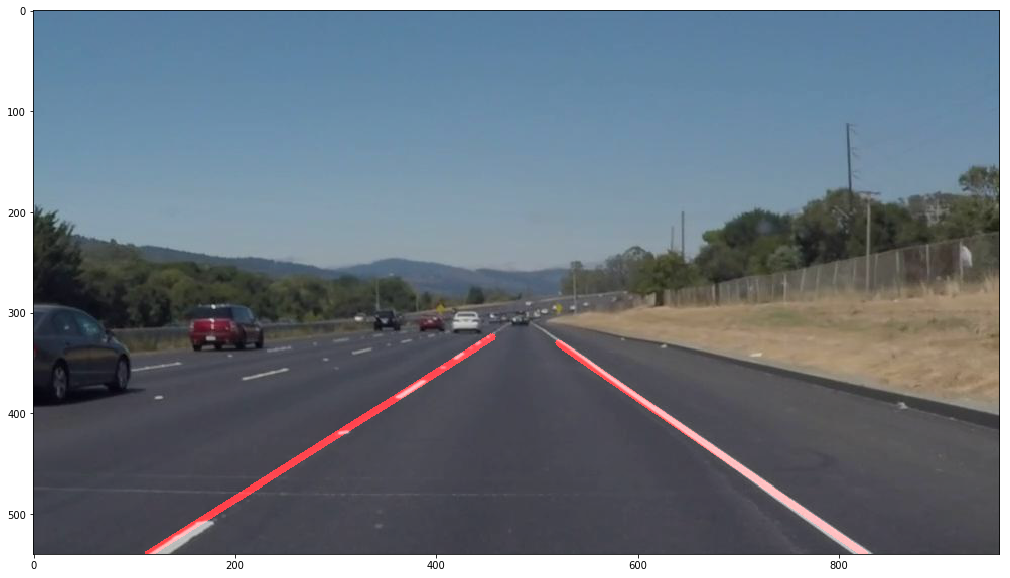

In [351]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

#reading in an image
image = mpimg.imread('test_images/screenshot2.jpeg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)

    
# Apply Gaussian filter to smooth image and remove noise
gauss = cv2.GaussianBlur(image,(5,5), 0)

# Do Canny Edge Detection   (skipping the white/yellow mask leads to extra lines)
low_threshold = 50
high_threshold = 150
canny_edges = canny(gauss,low_threshold,high_threshold)

# Region of Interest
vertices = [np.array([[0,540],[465,320],[500,320],[950,540]], dtype=np.int32)]
ROI_masked = region_of_interest(canny_edges, vertices)


 # Hough Transform
#rho and theta are the distance and angular resolution of the grid in Hough space
#threshold is minimum number of intersections in a grid for candidate line to go to output
rho = 2
theta = np.pi/180
threshold = 30
min_line_len = 50
max_line_gap = 100

hough_image = hough_lines(ROI_masked, rho, theta, threshold, min_line_len, max_line_gap)

# Apply the lines to the original image
weighted_image = weighted_img(hough_image, image, α=.8, β=1., λ=0.)
    
plt.figure(figsize=(20,10))
plt.imshow(weighted_image) 


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [59]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [352]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    
        # Apply Gaussian filter to smooth image and remove noise
    gauss = cv2.GaussianBlur(image,(5,5), 0)

    # Do Canny Edge Detection   (skipping the white/yellow mask leads to extra lines)
    low_threshold = 50
    high_threshold = 150
    canny_edges = canny(gauss,low_threshold,high_threshold)

    # Region of Interest
    vertices = [np.array([[0,540],[465,320],[500,320],[950,540]], dtype=np.int32)]
    ROI_masked = region_of_interest(canny_edges, vertices)


    # Hough Transform
    #rho and theta are the distance and angular resolution of the grid in Hough space
    #threshold is minimum number of intersections in a grid for candidate line to go to output
    rho = 2
    theta = np.pi/180
    threshold = 30
    min_line_len = 50
    max_line_gap = 100

    hough_image = hough_lines(ROI_masked, rho, theta, threshold, min_line_len, max_line_gap)

    # Apply the lines to the original image
    weighted_image = weighted_img(hough_image, image, α=.8, β=1., λ=0.)
    
    
    return weighted_image

Let's try the one with the solid white lane on the right first ...

In [353]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


 95%|█████████▌| 211/222 [00:02<00:00, 75.27it/s]

### Either horizontal or near vertical line ####


100%|█████████▉| 221/222 [00:02<00:00, 75.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 4.04 s, sys: 685 ms, total: 4.72 s
Wall time: 3.32 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [354]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [321]:
clip1.save_frame("screenshot2.jpeg", t=4)

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [85]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:11<00:00, 60.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 13.4 s, sys: 2.32 s, total: 15.7 s
Wall time: 11.8 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [88]:

def process_image_test(img):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    low_threshold = 50
    high_threshold = 150
    canny_edges = canny(img,low_threshold,high_threshold)

    # Need to convert to a 3 channel image since its expected for video processing (per the note)
    canny_image = np.dstack((canny_edges, canny_edges, canny_edges))
    
    return canny_image

def process_image_challenge(image):
    gray = grayscale(image)
    img_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    
    ##  Mask for only white and yellow lines
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])
    mask_yellow = cv2.inRange(img_hsv, lower_yellow, upper_yellow)
    mask_white = cv2.inRange(gray, 200, 255)
    mask_yw = cv2.bitwise_or(mask_white, mask_yellow)
    mask_yw_image = cv2.bitwise_and(gray, mask_yw)
                            
    
    gauss = cv2.GaussianBlur(mask_yw_image,(5,5), 0)

    # Do Canny Edge Detection   
    low_threshold = 50
    high_threshold = 150
    canny_edges = canny(gauss,low_threshold,high_threshold)

    # Region of Interest
    vertices = [np.array([[80,540],[465,315],[500,315],[900,540]], dtype=np.int32)]
    ROI_masked = region_of_interest(canny_edges, vertices)

    # Hough Transform
    rho = 1
    theta = np.pi/180
    threshold = 20
    min_line_len = 50
    max_line_gap = 50
    hough_image = hough_lines(ROI_masked, rho, theta, threshold, min_line_len, max_line_gap)

    # Apply the lines to the original image
    weighted_image = weighted_img(hough_image, image, α=.8, β=1., λ=0.)
    
    return weighted_image


challenge_output = 'test_videos_output/challenge.mp4'
#clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')

challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:07<00:00, 33.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 9.74 s, sys: 1.34 s, total: 11.1 s
Wall time: 8.47 s


In [89]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [ ]:
clip3.save_frame("sfv1.jpeg", t=2)